In [ ]:
!pip install opencv-python
!pip install tqdm
!pip install numba

### Imports

In [39]:
import numpy as np
import time
from jet_center import analyze_jet_center ,threshold , denoise

### Load files

In [40]:
videos_paths = os.listdir('Videos')
loaded_video_name = None
loaded_video = None

gui = interact.options(manual=True,manual_name='load video')

@gui(file = videos_paths)
def load_video(file):
    '''
    Load the data video stored in numpy array of shape (frames,row,col,channel)
    '''
    global loaded_video,loaded_video_name
    
    #memap to load partially into ram
    loaded_video = np.load(f'Videos/{file}',mmap_mode='r')
    
    loaded_video_name= file
    
    print(f'loaded {file} \nshape = {loaded_video.shape}')
    



interactive(children=(Dropdown(description='file', options=('10%-0% -1-R1-HR-video.npy', '10%-1% -1-R1-HR-vide…

In [41]:
def draw_horizontal_line(array,pos=0,thick=1,color=(255,0,255)):
    if len(array.shape)==3 : 
        array[pos-thick:pos+thick,:,:] = color ;
        return array
    
    elif len(array.shape)==2 :
        array[pos-thick:pos+thick,:] = color[0] ;
        return array
    
def freq_psd(t,f):
    
    dt = t[1]-t[0]
    
    n=len(t)
    
    fhat=np.fft.fft(f,n)
    
    PSD = fhat*np.conjugate(fhat) /n
    
    freq = (1/(dt*n))*np.arange(n)
    
    L = np.arange(1,np.floor(n/2),dtype='int')
    
    return freq[L] , PSD[L]


### Tune threshold and denoising values

In [38]:
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display

frame_slider = IntSlider(min=0,max=loaded_video.shape[0]-1,layout=Layout(width='90%'),continuous_update=False)
threshold_slider = IntSlider(min=0,max=255,value=168,layout=Layout(width='90%'),continuous_update=False)
tolerance_slider = IntSlider(min=0,max=255,value=0,layout=Layout(width='90%'),continuous_update=False)
row_slider = IntSlider(min=0,max=loaded_video.shape[1],layout=Layout(width='90%'),step=1,value=1700,continuous_update=False)

gui_box= VBox([frame_slider,threshold_slider,tolerance_slider,row_slider])


global_row_frame,global_row_value = None , 1700

gui = interact.options(manual=False,manual_name='analyze')


@gui(frame =frame_slider,\
          threshold_value = threshold_slider,\
          tolerance_value = tolerance_slider,\
          row_value = row_slider,\
          plot=True ,analyze=False,save=False )
def jet_center_analyze_gui(frame,  \
                       threshold_value, \
                       tolerance_value ,\
                       row_value,  \
                       plot=False,analyze=False,save=False ):
    
    global loaded_video ,global_row_frame,global_row_value,loaded_video_name
    
    if plot:
        plt.figure(1)
        plt.figure(figsize=(20,10))
        plt.yticks([]);plt.xticks([])
        img = loaded_video[frame:frame+1,:,:,:]

        #show raw image
        plt.subplot(1,3,1)
        plt.imshow(np.flip(draw_horizontal_line(img[0].copy(),pos=row_value,thick=3),2))
        plt.title('Raw image')

        #show threshold image
        plt.subplot(1,3,2)
        thresh = threshold(img,threshold_value) 
        print(thresh.shape)
        if plot : plt.imshow(thresh[0,:,:,0],cmap='gray')
        plt.title('Thresholded image')

        #show streak image
        plt.subplot(1,3,3)
        denoised = denoise(thresh,tolerance = tolerance_value )
        if plot:plt.imshow(denoised[0,:,:,0],cmap='gray')     
        plt.title('Denoised image')
    
    if analyze:
        #calculate the edges using the analysis pipeline
        tic =time.time()
        print('analysis in progress ...',end='\r')
        global_row_frame = analyze_jet_center(loaded_video , threshold_value , tolerance_value)
        toc=time.time()
        print(f'analysis done in {toc-tic} s')
        print(global_row_frame.shape)
        
    if analyze and save :
        np.save(f'Time series/{loaded_video_name}-timeseries',global_row_frame)
        print('saved!')


interactive(children=(IntSlider(value=0, continuous_update=False, description='frame', layout=Layout(width='90…

### Analyze and plot

In [31]:
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 

import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

mpl.rcParams['figure.dpi'] = 72
mpl.rcParams.update({'font.size': 22})
mpl.rcParams['axes.linewidth'] = 1


In [33]:
row_slider = IntSlider(min=0,max=loaded_video.shape[1],layout=Layout(width='100%'),step=1,value=global_row_value,continuous_update=False)
time_slice_slider = widgets.FloatRangeSlider(min=0,max=7.5,value=(1.5,7.5) ,step=0.1 ,layout=Layout(width='100%'),continuous_update=False)

@interact(row_value =row_slider,time_slice = time_slice_slider)
def jet_center_analysis_plot(row_value,time_slice,plot=True,save_fig=False):
    #get the desired row
    f= global_row_frame[row_value]

    #original video fps 
    fps=60.0

    # 32px/mm 1000mm/m
    scale = 32*1000

    #frame center
    center = 400 /2 

    t0p,tfp = time_slice
    
    #time slice
    t0=t0p #len(f)/fps * (t0p/100)
    tf=tfp #len(f)/fps  *(tfp/100)

    #adjust signal to frame center
    f = f- (center)
    f = f/ (scale)

    t=np.arange(t0,tf,1/fps)

    f=f[int(t0*fps):int(tf*fps)]
    
    print('t0=',t0,'\ntf=',tf)
    
    if plot :
        plt.figure(2)
        plt.figure(figsize=(35,10))

        plt.subplot(1,4,1)
        plt.plot(t,f,'-k',linewidth=3)
        plt.xlabel('$t (s)$',fontsize=40);
        plt.ylabel('$Jet \ center \ position\ (m)$',fontsize=40)
        plt.xticks(np.arange(t0,tf,1))
        plt.tick_params(which='both', size=10, width=2, direction='in')
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

        ff,psd = freq_psd(t,f)

        plt.subplot(1,4,2)
        plt.semilogx(ff,psd,'-k',linewidth=3)
        plt.title('$semi-log-x \ plot$');plt.xlabel('$Frequency (Hz)$',fontsize=40);plt.ylabel('$PSD$',fontsize=40)
        plt.tick_params(which='both', size=10, width=2, direction='in')  

        #         psd[0]=0

        plt.subplot(1,4,3)
        plt.loglog(ff,psd,'-k',linewidth=3)
        plt.title('$log-log \ plot$');plt.xlabel('$Frequency (Hz)$',fontsize=40);plt.ylabel('$PSD$',fontsize=40)
        plt.tick_params(which='both', size=10, width=2, direction='in')  
        
        
        plt.subplot(1,4,4)
        plt.imshow(draw_horizontal_line(loaded_video[loaded_video.shape[0]//2].copy(),pos=row_value,thick=3))
        
        if save_fig :
            plt.savefig(f'Figures/{loaded_video_name}@pos={global_row_value}.svg')

interactive(children=(IntSlider(value=1700, continuous_update=False, description='row_value', layout=Layout(wi…

### Test functions

C:\Users\m\.conda\envs\deep\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\m\.conda\envs\deep\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, '$ log \\ log $')

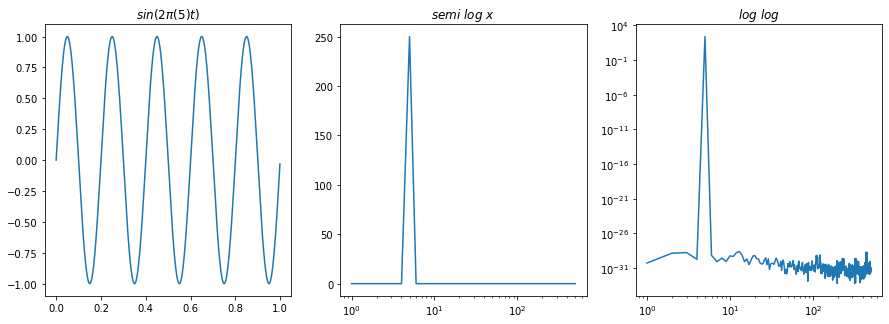

In [27]:
# frequency psd method validation
    
dt =1e-3
t=np.arange(0,1,dt)
f =np.sin(2*np.pi*5*t) #+ np.sin(2*np.pi*120*t)
    
freq,psd = freq_psd(t,f)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1);plt.plot(t,f);plt.title("$sin(2 \pi   (5) t)$")
plt.subplot(1,3,2);plt.semilogx(freq,psd);plt.title("$ semi  \ log  \ x$")
plt.subplot(1,3,3);plt.loglog(freq,psd);plt.title("$ log \ log $")